In [1]:
#Wrangling imports
import pandas as pd
import glob
import numpy as np
from datetime import datetime
import re
from scipy import stats

#Graphing imports
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go

pd.set_option('display.max_columns', 50)

## Data wrangling

In [2]:
path = "/Users/ridleyleisy/Documents/lambda/unit_one/DS-Unit-1-Sprint-5-Data-Storytelling-Blog-Post/kickstarter_data/"

In [3]:
all_files = glob.glob(path + "/*.csv")

cols = ['backers_count','blurb','category','converted_pledged_amount','country', 'created_at','currency',
      'deadline','goal','launched_at','location','pledged','slug','spotlight','staff_pick','state',
       'state_changed_at','usd_pledged']

In [4]:
li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0,encoding='utf-8',usecols=cols)
    li.append(df)

In [5]:
df = pd.concat(li, axis=0, ignore_index=True)
df = df.sort_values('created_at',ascending=False)
df.dropna(inplace=True)

In [6]:
df['state_changed_at'] = pd.to_datetime(df['state_changed_at'], unit='s').dt.date
df['launched_at'] = pd.to_datetime(df['launched_at'], unit='s').dt.date
df['deadline'] = pd.to_datetime(df['deadline'], unit='s').dt.date
df['created_at'] = pd.to_datetime(df['created_at'], unit='s').dt.date

In [7]:
def strip_name(s):
    result = re.search('"name":"(.*)","slug"',s)
    return result.group(1)

In [8]:
def strip_slug(s):
    result = re.search('"slug":"(.*)","position"',s)
    return result.group(1)

In [9]:
def strip_state(s):
    result = re.search('"state":"(.*)","type"',s)
  
    if result == None:
        return np.nan
    else:
        return result.group(1)

In [10]:
def strip_city(s):
    result = re.search('"localized_name":"(.*)","country"',s)
    if result == None:
        return np.nan
    else:
        return result.group(1)

In [11]:
def strip_type(s):
    result = re.search('"type":"(.*)","is_root"',s)
    return result.group(1)

In [12]:
df['category_name'] = df['category'].apply(strip_name)
df['slug_name'] = df['category'].apply(strip_slug)

In [13]:
df['state_abv'] = df['location'].apply(strip_state)
df['city'] = df['location'].apply(strip_city)
df['city_type'] = df['location'].apply(strip_type)

In [14]:
df = df.drop(['category','location'],axis=1)

In [15]:
df['length'] = (df['deadline'] - df['launched_at']).dt.days
df['avg_pledge_amount'] = df['converted_pledged_amount'] / df['backers_count']

# Blog post

My blog post will dive into the nitty gritty of Kickstarter for individuals curious about running their own campaign. It will give them best cateogies to choose from, highest probability timeframe and time of year, and what they can typically expect from their pledges and backers.

# Questions
1. What are the top categories for Kickstarters
2. How does being staff picked enhance your campaign? 
3. When should you launch your Kickstarter campaign?
4. How many backers should you expect based on the length of your campaign?
5. How successful are Kickstarter campaigns based on length of time
6. What cities are the most "creative" and produce the most Kickstarter results




## What are the most/least kickstarted categories?

In [16]:
top_ten = df['category_name'].value_counts().head(10)
bottom_ten = df['category_name'].value_counts().tail(10)

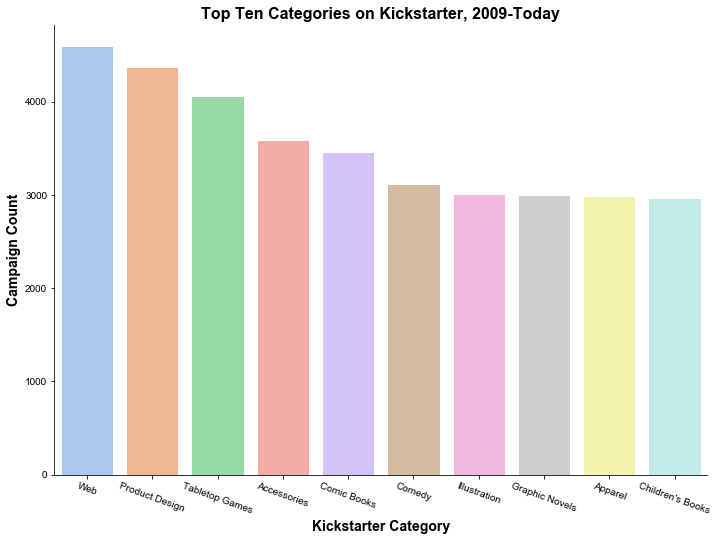

In [17]:
dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dims)
sns.set_style("ticks")
sns.barplot(top_ten.index,top_ten,ax=ax, palette='pastel')
sns.despine()
plt.title('Top Ten Categories on Kickstarter, 2009-Today',fontweight='bold',size=16)
plt.ylabel('Campaign Count',fontweight='bold',size=14)
plt.xlabel('Kickstarter Category',fontweight='bold',size=14)
plt.xticks(rotation=-20);


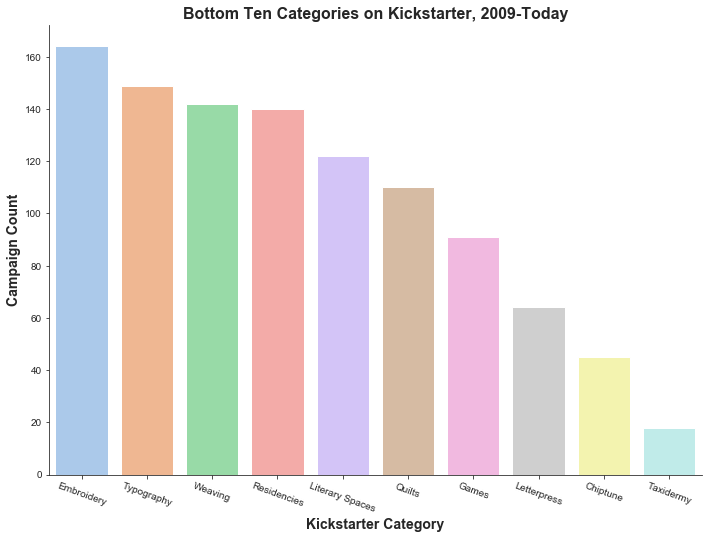

In [18]:
dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dims)
sns.set_style("ticks")
sns.barplot(bottom_ten.index,bottom_ten,palette='pastel')
sns.despine()
plt.title('Bottom Ten Categories on Kickstarter, 2009-Today',fontweight='bold',size=16)
plt.ylabel('Campaign Count',fontweight='bold',size=14)
plt.xlabel('Kickstarter Category',fontweight='bold',size=14)
plt.xticks(rotation=-20);

### Average of staff picked campaigns under 1000

In [19]:
df.loc[(df['staff_pick'] == False) & (df['goal'] <= 1000)]['goal'].value_counts().head()

1000.0    9318
500.0     7560
300.0     2519
600.0     1970
100.0     1962
Name: goal, dtype: int64

In [20]:
df.loc[(df['staff_pick'] == True) & (df['goal'] <= 1000)]['goal'].value_counts().head()

1000.0    653
500.0     362
600.0     133
800.0     130
300.0      94
Name: goal, dtype: int64

In [21]:
df.loc[df['staff_pick'] == True]['goal'].value_counts().head(10)

10000.0    1944
5000.0     1708
15000.0    1377
20000.0    1202
50000.0     983
25000.0     971
3000.0      901
30000.0     858
2000.0      760
1000.0      653
Name: goal, dtype: int64

### Effect of being promoted

#### Success Rates

In [22]:
df['state'].unique()

array(['live', 'canceled', 'suspended', 'successful', 'failed'],
      dtype=object)

In [23]:
staff_pick_successful_count = df[(df['staff_pick'] == True) & (df['state'] == 'successful')]['state'].value_counts()
staff_pick_fail_count = df[(df['staff_pick'] == True) & (df['state'] == 'failed')]['state'].value_counts()

In [24]:
no_staff_successful_count = df[(df['staff_pick'] == False) & (df['state'] == 'successful')]['state'].value_counts()
no_staff_fail_count = df[(df['staff_pick'] == False) & (df['state'] == 'failed')]['state'].value_counts()

In [25]:
total_campaigns = df.shape[0]

In [26]:
total_staff_picks = df.loc[df['staff_pick'] == True]['state'].count()
total_no_staff_picks = df.loc[df['staff_pick'] == False]['state'].count()

In [27]:
staff_pick_successful_count / total_staff_picks

successful    0.882536
Name: state, dtype: float64

In [28]:
no_staff_successful_count / total_no_staff_picks

successful    0.516499
Name: state, dtype: float64

In [29]:
df.loc[df['state'] == 'successful'].count()[0] / total_campaigns

0.5635396762619067

In [30]:
staff_picks_suc = pd.DataFrame({'Success':staff_pick_successful_count[0],'Failed':staff_pick_fail_count[0]
                                ,'Staff Picked':True},index=[0])
no_staff_picks_suc = pd.DataFrame({'Success':no_staff_successful_count[0],'Failed':no_staff_fail_count[0]
                                   ,'Staff Picked':False},index=[0])

In [31]:
df_s = pd.concat([staff_picks_suc,no_staff_picks_suc],ignore_index=True)

In [32]:
df_s.loc[:,'Success':'Failed'] = df_s.loc[:,'Success':'Failed'].div(df_s.loc[:,'Success':'Failed'].sum(axis=1), axis=0)

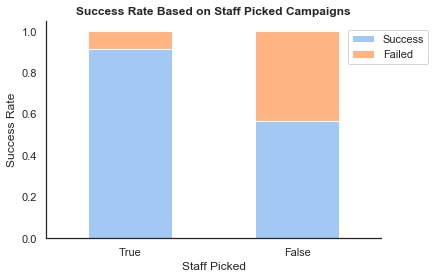

In [33]:
sns.set(palette='pastel',style='white')
df_s.set_index('Staff Picked').plot(kind='bar',stacked=True)
sns.despine()
plt.title('Success Rate Based on Staff Picked Campaigns',fontweight='bold')
plt.ylabel('Success Rate')
plt.legend(loc=(.9,.8))
plt.xticks(rotation=360);

#### Backers by Staff Pick

In [34]:
df_pledge = df[(np.abs(stats.zscore(df['backers_count'])) < 3)]

In [35]:
backer_total_mean = df_pledge['backers_count'].mean()
backer_total_median = df_pledge['backers_count'].median()

In [36]:
backer_staff_mean = df_pledge.loc[df['staff_pick'] == True]['backers_count'].mean()
backer_staff_median = df_pledge.loc[df['staff_pick'] == True]['backers_count'].median()

In [37]:
backer_no_staff_mean = df_pledge.loc[df['staff_pick'] == False]['backers_count'].mean()
backer_no_staff_median = df_pledge.loc[df['staff_pick'] == False]['backers_count'].median()

In [38]:
pledge_median = pd.DataFrame({'All':backer_total_median,
             'Staff Picked': backer_staff_median,
             "Staff Didn't Pick":backer_no_staff_median},
            index=['Backers'])

In [39]:
pledge_mean = pd.DataFrame({'All':backer_total_mean,
             'Staff Picked': backer_staff_mean,
             "Staff Didn't Pick":backer_no_staff_mean},
            index=['Backers'])

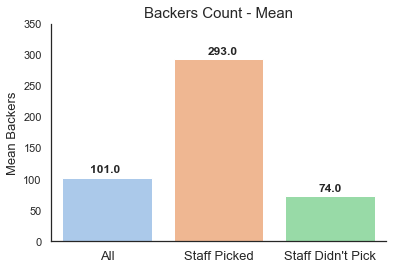

In [40]:
sns.barplot(pledge_mean.columns,pledge_mean.values[0],palette='pastel')
sns.despine()
plt.ylim(0,350)
plt.xticks(fontsize=13)
plt.ylabel('Mean Backers',fontsize=13)
plt.title('Backers Count - Mean',fontsize=15)
plt.text(x=-.15,y=110,s=round(pledge_mean['All'][0]),fontsize=12,fontweight='bold')
plt.text(x=0.9,y=300,s=round(pledge_mean['Staff Picked'][0]),fontsize=12,fontweight='bold')
plt.text(x=1.9,y=80,s=round(pledge_mean["Staff Didn't Pick"][0]),fontsize=12,fontweight='bold');

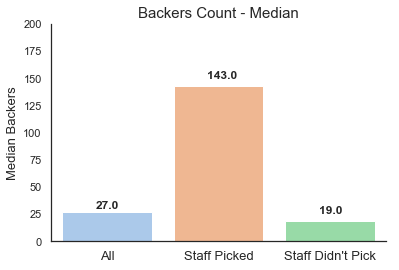

In [41]:
sns.barplot(pledge_median.columns,pledge_median.values[0],palette='pastel')
sns.despine()
plt.ylim(0,200)
plt.ylabel('Median Backers',fontsize=13)
plt.title('Backers Count - Median',fontsize=15)
plt.xticks(fontsize=13)
plt.text(x=-.1,y=30,s=pledge_median['All'][0],fontsize=12,fontweight='bold')
plt.text(x=0.9,y=150,s=pledge_median['Staff Picked'][0],fontsize=12,fontweight='bold')
plt.text(x=1.9,y=25,s=pledge_median["Staff Didn't Pick"][0],fontsize=12,fontweight='bold');

#### Categories picked by kickstarter

In [42]:
kickstart_select = (df.loc[df['staff_pick'] == True]['category_name'].value_counts() / df.loc[df['staff_pick'] == True]['category_name'].count()).sort_values().tail(10)

In [43]:
kickstart_select = pd.DataFrame(kickstart_select).reset_index()
kickstart_select.columns = ['Categories','Percent Selected']

In [44]:
kickstart_select.sort_values(['Percent Selected'],ascending=False)

,Categories,Percent Selected
9,Video Games,0.035780
8,Documentary,0.033370
7,Art Books,0.032332
6,Graphic Novels,0.031924
5,Photobooks,0.025621
4,Children's Books,0.024397
3,Comic Books,0.022877
2,Performances,0.021246
1,Narrative Film,0.019355
0,Hardware,0.018799


### Best Time of Year

In [47]:
launch = df.copy()

In [48]:
def month_to_quarter(dt):
    return (dt.month-1)//3 + 1

In [49]:
def year_col(dt):
    return dt.year

In [50]:
launch['quarter'] = launch['launched_at'].map(month_to_quarter)
launch['year'] = launch['launched_at'].map(year_col)

In [51]:
launch = pd.DataFrame(launch.groupby(['year','quarter'])['state'].value_counts())

In [52]:
launch = launch.unstack(level=2)

In [53]:
launch = launch['state'][['failed','successful','canceled']]

In [54]:
launch['total'] = launch['successful'] / (launch['failed']+launch['successful']+launch['canceled'])

In [55]:
launch = launch.reset_index()
launch = launch.loc[(launch['year'] > 2014) & (launch['year'] < 2019)]

In [56]:
q1_mean = launch.loc[(launch['quarter'] == 1) & (launch['year'] > 2014) & (launch['year'] < 2019)]['total'].mean()
q2_mean = launch.loc[(launch['quarter'] == 2) & (launch['year'] > 2014) & (launch['year'] < 2019)]['total'].mean()
q3_mean = launch.loc[(launch['quarter'] == 3) & (launch['year'] > 2014) & (launch['year'] < 2019)]['total'].mean()
q4_mean = launch.loc[(launch['quarter'] == 4) & (launch['year'] > 2014) & (launch['year'] < 2019)]['total'].mean()

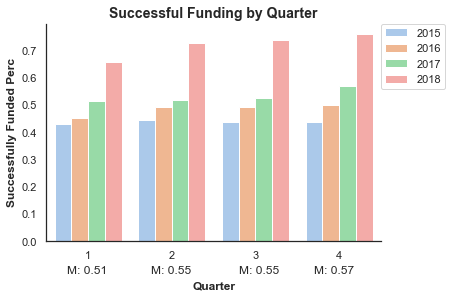

In [57]:
sns.barplot(x=launch['quarter'],y=launch['total'],hue=launch['year'],data=launch,palette='pastel')
plt.legend(loc=(1,.7))
sns.despine()
plt.xlabel('Quarter',fontweight='bold',labelpad=20)
plt.ylabel('Successfully Funded Perc',fontweight='bold')
plt.title('Successful Funding by Quarter',fontweight='bold',fontsize=14)
plt.text(x=-.25,y=-.12,s='M: {}'.format(round(q1_mean,ndigits=2)))
plt.text(x=.75,y=-.12,s='M: {}'.format(round(q2_mean,ndigits=2)))
plt.text(x=1.8,y=-.12,s='M: {}'.format(round(q3_mean,ndigits=2)))
plt.text(x=2.7,y=-.12,s='M: {}'.format(round(q4_mean,ndigits=2)));

### Expected Backers by Length of Kickstarter

In [58]:
suc_len = pd.DataFrame((df.loc[df['state'] == 'successful']['length'].value_counts() / df.shape[0]).head(20).sort_values())

In [59]:
fail_len = pd.DataFrame((df.loc[(df['state'] == 'failed') | (df['state'] == 'canceled') | (df['state']=='suspended')]['length'].value_counts() / df.shape[0]).head(20).sort_values())

In [60]:
s_avg_backers = df.loc[df['state'] == 'successful'].groupby('length')['backers_count'].median()
f_avg_backers = df.loc[(df['state'] == 'failed') | (df['state'] == 'canceled') | (df['state']=='suspended')].groupby('length')['backers_count'].median()

In [61]:
fail_len = pd.merge(fail_len,f_avg_backers,left_index=True,right_index=True)
suc_len = pd.merge(suc_len,s_avg_backers,left_index=True,right_index=True)

In [62]:
fail_len['success?'] = False
suc_len['success?'] = True

In [63]:
df1 = pd.concat([fail_len,suc_len],join='inner').reset_index()
df1.columns = ['Days','Perecentage','Backers Count','Successful?']

In [64]:
df1.head()

,Days,Perecentage,Backers Count,Successful?
0,36,0.002587,6.0,False
1,10,0.002664,1.0,False
2,59,0.002878,2.0,False
3,34,0.002921,6.0,False
4,50,0.003126,3.0,False


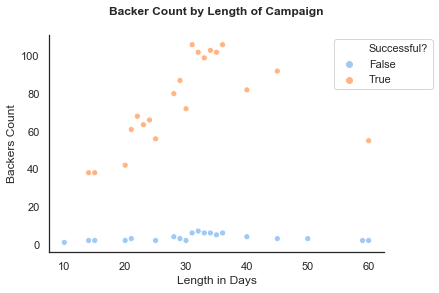

In [73]:
sns.scatterplot(x='Days',y='Backers Count',data=df1,palette='pastel',hue='Successful?')
sns.despine()
plt.xlabel('Length in Days')
plt.legend(loc=(.85,.75))
plt.title('Backer Count by Length of Campaign',fontweight='bold',pad=20);

### Ideal length of time for your Kickstarter

looking at successful kickstarters and their success percentage between launch/end times

In [74]:
time_frames = [[0,15],[15,30],[30,45],[45,60],[60,75],[75,90],[90,105]]

In [75]:
l = []

In [76]:
for time in time_frames:
    l.append((df[(df['state'] == 'successful') & (df['length'] > time[0]) & (df['length'] <= time[1])]).count()[0] / df.loc[(df['length'] > time[0]) & (df['length'] <= time[1])].count()[0])

In [77]:
time_string = [str(x) for x in time_frames]

In [78]:
df2 = pd.DataFrame([l,time_string]).T

In [79]:
df2.columns = ['perc','length']

In [80]:
df2

,perc,length
0,0.66968,"[0, 15]"
1,0.574509,"[15, 30]"
2,0.620389,"[30, 45]"
3,0.350347,"[45, 60]"
4,0.569832,"[60, 75]"
5,0.59322,"[75, 90]"
6,0.659574,"[90, 105]"


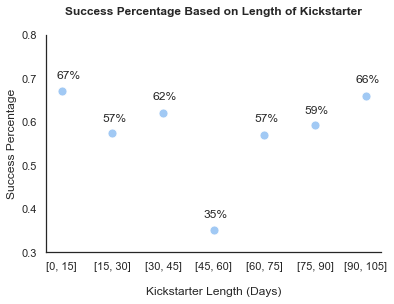

In [88]:
sns.scatterplot(y='perc',x='length',data=df2,palette='pastel',s=80)
sns.despine()
plt.ylim(.30,.80)
plt.xlabel('Kickstarter Length (Days)',labelpad=15)
plt.ylabel('Success Percentage')
plt.title('Success Percentage Based on Length of Kickstarter',fontweight='bold',pad=20)
plt.text(x=-.1,y=.7,s='67%')
plt.text(x=.8,y=.6,s='57%')
plt.text(x=1.8,y=.65,s='62%')
plt.text(x=2.8,y=.38,s='35%')
plt.text(x=3.8,y=.6,s='57%')
plt.text(x=4.8,y=.62,s='59%')
plt.text(x=5.8,y=.69,s='66%');

### Where are Kickstarters Started?


In [342]:
us_df = df.loc[(df['country'] == 'US') & (df['state_abv'].str.len() <= 2)]

In [338]:
counts = pd.DataFrame(us_df.groupby('state_abv')['state_abv'].value_counts(),index=None)

In [350]:
counts = counts.reset_index(level=1, drop=True)
counts.columns = ['count']
counts.reset_index(inplace=True)

In [382]:
data = [go.Choropleth(
    autocolorscale = True,
    locations = counts['state_abv'],
    z = counts['count'],
    locationmode = 'USA-states',
    marker = go.choropleth.Marker(
        line = go.choropleth.marker.Line(
            color = 'rgb(255,255,255)',
            width = 2
        )),
    colorbar = go.choropleth.ColorBar(
        title = "Number of Kickstarters")
)]

layout = go.Layout(
    title = go.layout.Title(
        text = 'Kickstarters By State'
    ),
    geo = go.layout.Geo(
        scope = 'usa',
        projection = go.layout.geo.Projection(type = 'albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)'),
)

In [383]:
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'kickstarter_map')

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead

